============================================================
# Aadhaar Demographic Update Dataset  
Data Cleaning, Preprocessing, Standardisation & Validation  

Author: Nitish Kumar  
============================================================

## 1. Introduction

The Aadhaar ecosystem supports India’s digital identity infrastructure and enables access to a wide range of public and private services. Beyond initial enrolment, demographic updates—such as changes in name, address, date of birth, gender, and mobile number—represent continuous interactions between residents and the identity system.

These updates are not random administrative events. Instead, they reflect deeper societal and lifecycle dynamics including:

- Population mobility and migration  
- Urbanisation and address transitions  
- Educational and employment movement  
- Marriage-related demographic changes  
- Adolescent-to-adult biometric and demographic transitions  
- Increased digital service dependency  

Understanding demographic update patterns is therefore essential for:

- Anticipating administrative workload  
- Planning update infrastructure capacity  
- Identifying lifecycle-driven demand surges  
- Detecting regional inequalities in service access  
- Supporting proactive governance rather than reactive reporting  

This analysis transforms the Aadhaar demographic update dataset from a static operational record into a dynamic signal of population lifecycle behaviour and administrative pressure.

---

## 2. Dataset Description

### Aadhaar Demographic Update Dataset (UIDAI)

The Aadhaar Demographic Update dataset provides aggregated information on updates made to residents’ demographic details linked to Aadhaar.

The dataset is published by UIDAI through multiple API-generated CSV files due to its large volume and is aggregated at different geographic and temporal levels.

### Key Characteristics

- **Granularity**:
  - State
  - District
  - PIN code

- **Temporal Resolution**:
  - Daily records aggregated into monthly and yearly periods

- **Update Scope**:
  - Demographic information only  
  - Does *not* include biometric modalities

---

### Dataset Columns Used

| Column Name | Description |
|------------|-------------|
| `date` | Date on which demographic updates were recorded |
| `state` | Reported state or union territory name |
| `district` | District name |
| `pincode` | Six-digit Indian postal PIN code |
| `demo_age_5_17` | Number of demographic updates for residents aged 5–17 years |
| `demo_age_17_` | Number of demographic updates for residents aged 18 years and above |
| `year` | Extracted year from date field |
| `month` | Extracted month from date field |
| `state_clean` | Standardised canonical state / UT name used for analysis |

---

### Sample Record

date : 01-03-2025
state : Uttar Pradesh
district : Gorakhpur
pincode : 273213
demo_age_5_17 : 49
demo_age_17_ : 529

1️⃣ Setup & Configuration
(Technical Implementation | Reproducibility)

In [9]:
# Core libraries
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (10, 5)

# Configurable parameters
Z_SCORE_THRESHOLD = 3

RANDOM_SEED = 42


# 3. Data Cleaning & Preprocessing

Includes:

Data loading

Merging 3 files

Column standardisation

Date parsing

Geo validation

State name canonicalisation

Duplicate handling

# 📘 Purpose
Ensure dataset reliability without modifying government-published values.

In [1]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. CONFIGURATION
# ------------------------------------------------------------

ROLLING_WINDOW = 3

files = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv",
]

# ------------------------------------------------------------
# 2. LOAD & MERGE RAW DATA
# ------------------------------------------------------------
# Government data is usually provided in chunks.
# We concatenate without altering original records.

df_list = [pd.read_csv(file) for file in files]
df_raw = pd.concat(df_list, ignore_index=True)

# Keep untouched raw copy for audit traceability
df = df_raw.copy()

# ------------------------------------------------------------
# 3. STANDARDISE COLUMN NAMES
# ------------------------------------------------------------
# Prevent case-sensitive bugs during analysis

df.columns = df.columns.str.lower().str.strip()

# ------------------------------------------------------------
# 4. DATE STANDARDISATION
# ------------------------------------------------------------
# Convert string date → datetime
# errors='coerce' safely handles invalid dates without crash

df["date"] = pd.to_datetime(
    df["date"],
    format="%d-%m-%Y",
    errors="coerce"
)

# Create time dimensions for aggregation
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ------------------------------------------------------------
# 5. GEOGRAPHIC VALIDATION
# ------------------------------------------------------------
# Remove rows with corrupted geographic identifiers.
# Example invalid rows:
#   02-09-2025,100000,100000,100000,0,0,3

valid_geo_mask = (
    df["state"].astype(str).str.match("^[A-Za-z .'-]+$") &
    df["district"].astype(str).str.match("^[A-Za-z .'-]+$") &
    df["pincode"].astype(str).str.match("^[1-9][0-9]{5}$")
)

df = df[valid_geo_mask]

# ------------------------------------------------------------
# 6. HANDLE MISSING VALUES
# ------------------------------------------------------------

# Critical geography cannot be missing
df.dropna(subset=["state", "district"], inplace=True)

# Age buckets:
# Missing values mean "no enrolments recorded", not unknown.
age_cols = ["demo_age_5_17","demo_age_17_"]

df[age_cols] = (
    df[age_cols]
    .fillna(0)
    .astype(int)
)

# ------------------------------------------------------------
# 7. PINCODE VALIDATION
# ------------------------------------------------------------
# Indian PIN codes must be exactly 6 digits

df = df[df["pincode"].astype(str).str.len() == 6]

# ============================================================
# 8. STATE NAME STANDARDISATION
# Geographic Standardisation: State Naming Conflict Resolution
# ============================================================
# WHY THIS STEP IS REQUIRED
# ------------------------------------------------------------
# The UIDAI enrolment dataset is aggregated from multiple
# administrative sources across years and systems.
#
# As a result, the same Indian state or UT may appear with:
#   - different spellings
#   - inconsistent casing
#   - merged / renamed administrative entities
#   - legacy names from earlier years
#
# Examples:
#   - "WEST BENGAL", "West Bengal", "west bengal"
#   - "andhrapradesh", "Andhra Pradesh"
#   - "Daman and Diu" vs
#   - "Dadra and Nagar Haveli and Daman and Diu"
#   - legacy names (Orissa)
#   - old UT names (Pondicherry)
#   - spelling errors
#   - extra whitespace
#
# If not resolved:
#   - States appear multiple times in analysis
#   - Enrolment totals become incorrect
#   - Inequality index is artificially inflated
#   - Policy recommendations become misleading
#
# IMPORTANT GOVERNANCE PRINCIPLE
# ------------------------------------------------------------
# The original dataset MUST NOT be modified.
# Standardisation is applied only in the analytical layer.
#
# Therefore:
#   - Original column:  df["state"]
#   - Canonical column: df["state_clean"]
#
# All grouping, aggregation, and visualisation MUST use
# the canonical column only.
# ============================================================

# Normalize text
df["state_clean"] = (
    df["state"]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)
# A. SPELLING + LEGACY NAME CORRECTIONS
# Mapping dictionary
state_mapping = {
    # Historical names
    "orissa": "Odisha",
    "pondicherry": "Puducherry",
    "uttaranchal": "Uttarakhand",

    # Andhra Pradesh variations
    "andhrapradesh": "Andhra Pradesh",
    "andhra pradesh": "Andhra Pradesh",
    "uttar Pradesh": "Uttar Pradesh",
    "uttarpradesh": "Uttar Pradesh",

    # West Bengal variations
    "west bengal": "West Bengal",
    "westbengal": "West Bengal",
    "WEST BENGAL": "West Bengal",
    "west bangal": "West Bengal",
    "west  bengal": "West Bengal",
    "west   bengal": "West Bengal",
    "West Bengli": "West Bengal",

    # Dadra & Daman administrative merger (2020)
    "dadra and nagar haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "the dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    
    # Andaman & Nicobar Islands naming variations
    "andaman and nicobar": "Andaman and Nicobar Islands",
    "andaman and nicobar islands": "Andaman and Nicobar Islands",
    "andaman & nicobar islands": "Andaman And Nicobar Islands",
    # Jammu & Kashmir naming variations
    "jammu & kashmir": "Jammu and Kashmir",
    "jammu and kashmir": "Jammu and Kashmir",

    # Delhi naming variations
    "nct of delhi": "Delhi",
    "delhi nct": "Delhi",

    # Telangana common misspelling
    "telengana": "Telangana",
    # Chhattisgarh common misspelling
    "chhatisgarh": "Chhattisgarh",
}

df["state_clean"] = (
    df["state_clean"]
    .replace(state_mapping)
    .str.title()
)

# ------------------------------------------------------------
# 9. OFFICIAL INDIA STATE–UT MASTER VALIDATION
# ------------------------------------------------------------

official_states_ut = {
    "Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar",
    "Chhattisgarh", "Goa", "Gujarat", "Haryana",
    "Himachal Pradesh", "Jharkhand", "Karnataka", "Kerala",
    "Madhya Pradesh", "Maharashtra", "Manipur", "Meghalaya",
    "Mizoram", "Nagaland", "Odisha", "Punjab", "Rajasthan",
    "Sikkim", "Tamil Nadu", "Telangana", "Tripura",
    "Uttar Pradesh", "Uttarakhand", "West Bengal",

    # Union Territories
    "Andaman And Nicobar Islands", "Chandigarh",
    "Dadra And Nagar Haveli And Daman And Diu",
    "Delhi", "Jammu And Kashmir", "Ladakh",
    "Lakshadweep", "Puducherry"
}
# A. Identify invalid / unknown state names
unknown_states = sorted(
    set(df["state_clean"].unique()) - official_states_ut
)

print("--------------------------------------------------")
print("Unknown / invalid state names detected:")
print(unknown_states)
print("--------------------------------------------------")

# B. Remove geographically corrupted records

invalid_geo_mask = ~df["state_clean"].isin(official_states_ut)

print("Removing geographically corrupted rows for:")
print(sorted(df.loc[invalid_geo_mask, "state_clean"].unique()))

df = df[~invalid_geo_mask]

print("--------------------------------------------------")
print("Final valid States / UTs :", df["state_clean"].nunique())
print("--------------------------------------------------")

# C. Remove duplicate records

# Prevents double counting across UIDAI API data chunks
df.drop_duplicates(inplace=True)

# D. Create final clean analytical dataset

df_clean = df.copy()

print("--------------------------------------------------")
print("RAW ROWS   :", len(df_raw))
print("CLEAN ROWS :", len(df_clean))
print("DATA READY FOR ANALYSIS ✅")
print("--------------------------------------------------")

df_clean.head()

--------------------------------------------------
Unknown / invalid state names detected:
['Balanagar', 'Darbhanga', 'Jaipur', 'Madanapalle', 'Nagpur', 'Raja Annamalai Puram', 'West Bengli']
--------------------------------------------------
Removing geographically corrupted rows for:
['Balanagar', 'Darbhanga', 'Jaipur', 'Madanapalle', 'Nagpur', 'Raja Annamalai Puram', 'West Bengli']
--------------------------------------------------
Final valid States / UTs : 36
--------------------------------------------------
--------------------------------------------------
RAW ROWS   : 2071700
CLEAN ROWS : 1572474
DATA READY FOR ANALYSIS ✅
--------------------------------------------------


,date,state,district,pincode,demo_age_5_17,demo_age_17_,year,month,state_clean
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529,2025,3,Uttar Pradesh
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375,2025,3,Andhra Pradesh
2,2025-03-01,Gujarat,Rajkot,360006,65,765,2025,3,Gujarat
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314,2025,3,Andhra Pradesh
4,2025-03-01,Rajasthan,Udaipur,313801,45,785,2025,3,Rajasthan


# 4. FEATURE GENERATION/ENGINEERING

This section creates new analytical variables.

🔹 4.1 Create Total Demographic Updates

In [2]:
# ------------------------------------------------------------
# 4.1 Total Demographic Updates
# ------------------------------------------------------------
# Represents total demographic corrections performed
# during a given time and geography.

df_clean["total_demo_updates"] = (
    df_clean["demo_age_5_17"] +
    df_clean["demo_age_17_"]
)
df_clean["total_demo_updates"].head()


0    578
1    397
2    830
3    338
4    830
Name: total_demo_updates, dtype: int32

🔹 4.2 Time Aggregation (Monthly)

Government reporting is monthly / quarterly, not daily.
🔹 State–Month Level (Primary Unit)

In [3]:
# ------------------------------------------------------------
# 4.2 State–Month Aggregation
# ------------------------------------------------------------
# Core analytical granularity used for:
# - time series trends
# - momentum analysis
# - saturation indicators
# - governance planning

state_month_demo = (
    df_clean
    .groupby(["state_clean", "year", "month"], as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum",
        "total_demo_updates": "sum"
    })
)
state_month_demo.head()

,state_clean,year,month,demo_age_5_17,demo_age_17_,total_demo_updates
0,Andaman And Nicobar Islands,2025,3,100,831,931
1,Andaman And Nicobar Islands,2025,7,20,199,219
2,Andaman And Nicobar Islands,2025,9,56,562,618
3,Andaman And Nicobar Islands,2025,10,58,395,453
4,Andaman And Nicobar Islands,2025,11,104,809,913


🔹4.3 Aggregate at District Level (for targeting)

In [4]:
# ------------------------------------------------------------
# 4.3 District-Level Aggregation
# ------------------------------------------------------------
# Used later for:
# - high-burden district identification
# - governance risk ranking
# - targeted infrastructure planning

district_demo_summary = (
    df_clean
    .groupby(["state_clean", "district"], as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum",
        "total_demo_updates": "sum"
    })
)
district_demo_summary.head()

,state_clean,district,demo_age_5_17,demo_age_17_,total_demo_updates
0,Andaman And Nicobar Islands,Nicobar,34,466,500
1,Andaman And Nicobar Islands,North And Middle Andaman,76,1220,1296
2,Andaman And Nicobar Islands,South Andaman,347,2291,2638
3,Andhra Pradesh,Adilabad,1948,20464,22412
4,Andhra Pradesh,Alluri Sitharama Raju,1200,8758,9958


🔹 4.4 Demographic Update Composition Ratios

In [5]:
# ------------------------------------------------------------
# 4.4 Age Composition of Demographic Updates
# ------------------------------------------------------------
# Indicates which population segment drives update demand.

state_month_demo["youth_update_share"] = (
    state_month_demo["demo_age_5_17"] /
    state_month_demo["total_demo_updates"]
)

state_month_demo["adult_update_share"] = (
    state_month_demo["demo_age_17_"] /
    state_month_demo["total_demo_updates"]
)
state_month_demo[[
    "state_clean", "year", "month",
    "youth_update_share", "adult_update_share"
]].head()

,state_clean,year,month,youth_update_share,adult_update_share
0,Andaman And Nicobar Islands,2025,3,0.107411,0.892589
1,Andaman And Nicobar Islands,2025,7,0.091324,0.908676
2,Andaman And Nicobar Islands,2025,9,0.090615,0.909385
3,Andaman And Nicobar Islands,2025,10,0.128035,0.871965
4,Andaman And Nicobar Islands,2025,11,0.113910,0.886090


🔹 4.5 Demographic Update Saturation Index

✔ Near 1 → saturation
✔ Low → enrolment expansion needed

In [6]:
# ------------------------------------------------------------
# 4.5 Update Saturation Index
# ------------------------------------------------------------
# Indicates whether update volumes have stabilised.
#
# High value → mature Aadhaar ecosystem
# Low value  → active demographic churn

state_month_demo["update_saturation_index"] = (
    state_month_demo["adult_update_share"] /
    state_month_demo.groupby("state_clean")["adult_update_share"].transform("max")
)
state_month_demo[[
    "state_clean", "year", "month",
    "update_saturation_index"
]].head()

,state_clean,year,month,update_saturation_index
0,Andaman And Nicobar Islands,2025,3,0.981530
1,Andaman And Nicobar Islands,2025,7,0.999220
2,Andaman And Nicobar Islands,2025,9,1.000000
3,Andaman And Nicobar Islands,2025,10,0.958851
4,Andaman And Nicobar Islands,2025,11,0.974383


🔹4.6 Future Update Pressure Indicator

🎯 Predicts:
biometric update load
demographic update demand

In [7]:
# ------------------------------------------------------------
# 4.6 Future Update Pressure Index
# ------------------------------------------------------------
# Youth-heavy update distribution implies
# future surge in demographic & biometric updates.

state_month_demo["future_update_pressure"] = (
    state_month_demo["demo_age_5_17"] /
    state_month_demo["total_demo_updates"]
)
state_month_demo[[
    "state_clean", "year", "month",
    "future_update_pressure"
]].head()


,state_clean,year,month,future_update_pressure
0,Andaman And Nicobar Islands,2025,3,0.107411
1,Andaman And Nicobar Islands,2025,7,0.091324
2,Andaman And Nicobar Islands,2025,9,0.090615
3,Andaman And Nicobar Islands,2025,10,0.128035
4,Andaman And Nicobar Islands,2025,11,0.113910


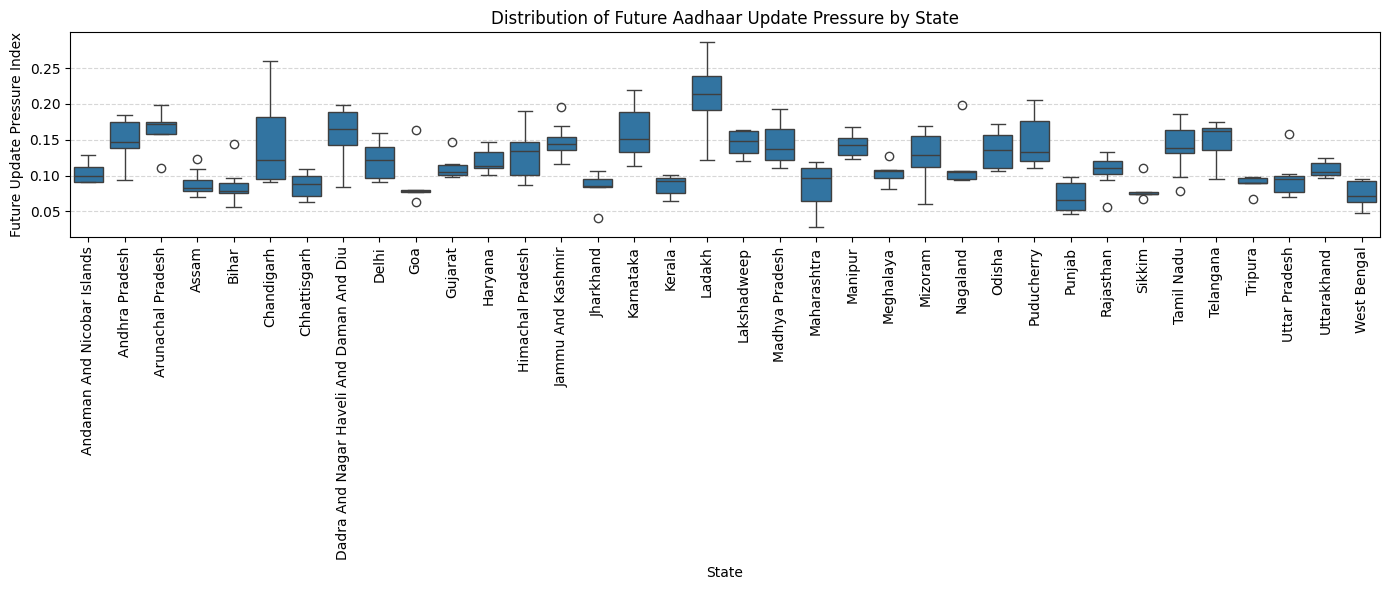

In [10]:
plt.figure(figsize=(14,6))

sns.boxplot(
    x="state_clean",
    y="future_update_pressure",
    data=state_month_demo
)

plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Future Update Pressure Index")
plt.title("Distribution of Future Aadhaar Update Pressure by State")

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

🔹 4.7 Month-on-Month Update Growth

Used to detect:
enrolment surges
slowdown phases

In [11]:
# ------------------------------------------------------------
# 4.7 Month-on-Month Growth
# ------------------------------------------------------------

state_month_demo = state_month_demo.sort_values(
    ["state_clean", "year", "month"]
)

state_month_demo["mom_update_growth"] = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .pct_change() * 100
)
state_month_demo[[
    "state_clean", "year", "month",
    "mom_update_growth"
]].head()

,state_clean,year,month,mom_update_growth
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,-76.476907
2,Andaman And Nicobar Islands,2025,9,182.191781
3,Andaman And Nicobar Islands,2025,10,-26.699029
4,Andaman And Nicobar Islands,2025,11,101.545254


🔹 4.8 Rolling Volatility (Operational Stability)
📘 High volatility → infra or reporting instability.

In [12]:
# ------------------------------------------------------------
# 4.8 Rolling Momentum
# ------------------------------------------------------------
# Smooths volatility and reveals structural trend direction.

ROLLING_WINDOW = 3

state_month_demo["rolling_update_momentum"] = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .rolling(ROLLING_WINDOW)
    .mean()
    .reset_index(level=0, drop=True)
)
state_month_demo[[
    "state_clean", "year", "month",
    "rolling_update_momentum"
]].head()

,state_clean,year,month,rolling_update_momentum
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,NaN
2,Andaman And Nicobar Islands,2025,9,589.333333
3,Andaman And Nicobar Islands,2025,10,430.000000
4,Andaman And Nicobar Islands,2025,11,661.333333


🔹 4.9 Update Volatility Index

In [13]:
# ------------------------------------------------------------
# 4.9 Update Volatility Index
# ------------------------------------------------------------
# High volatility may indicate:
# - policy shocks
# - infrastructure outages
# - seasonal address change patterns

state_month_demo["update_volatility"] = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .rolling(ROLLING_WINDOW)
    .std()
    .reset_index(level=0, drop=True)
)
state_month_demo[[
    "state_clean", "year", "month",
    "update_volatility"
]].head()

,state_clean,year,month,update_volatility
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,NaN
2,Andaman And Nicobar Islands,2025,9,356.864587
3,Andaman And Nicobar Islands,2025,10,200.491895
4,Andaman And Nicobar Islands,2025,11,233.041484


🔹 4.10 Demographic Lifecycle Transition Index (CREATIVE METRIC)

In [14]:
# ------------------------------------------------------------
# 4.10 Lifecycle Transition Index (LTI)
# ------------------------------------------------------------
# Measures structural movement from youth-driven
# updates towards adult-dominated updates.

state_month_demo["demographic_lifecycle_index"] = (
    state_month_demo["adult_update_share"] -
    state_month_demo
        .groupby("state_clean")["adult_update_share"]
        .shift(1)
)
state_month_demo[[
    "state_clean", "year", "month",
    "demographic_lifecycle_index"
]].head()

,state_clean,year,month,demographic_lifecycle_index
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,0.016087
2,Andaman And Nicobar Islands,2025,9,0.000709
3,Andaman And Nicobar Islands,2025,10,-0.037420
4,Andaman And Nicobar Islands,2025,11,0.014125


🔹 4.11 Governance Load Index

In [15]:
# ------------------------------------------------------------
# 4.11 Governance Load Index
# ------------------------------------------------------------
# Composite indicator representing operational burden.

state_month_demo["governance_load_index"] = (
    state_month_demo["future_update_pressure"].fillna(0) +
    state_month_demo["update_volatility"].fillna(0).rank(pct=True)
)
state_month_demo[[
    "state_clean", "year", "month",
    "governance_load_index"
]].head()

,state_clean,year,month,governance_load_index
0,Andaman And Nicobar Islands,2025,3,0.243099
1,Andaman And Nicobar Islands,2025,7,0.227012
2,Andaman And Nicobar Islands,2025,9,0.388013
3,Andaman And Nicobar Islands,2025,10,0.410563
4,Andaman And Nicobar Islands,2025,11,0.400156


In [16]:
state_month_demo.head()


,state_clean,year,month,demo_age_5_17,demo_age_17_,total_demo_updates,youth_update_share,adult_update_share,update_saturation_index,future_update_pressure,mom_update_growth,rolling_update_momentum,update_volatility,demographic_lifecycle_index,governance_load_index
0,Andaman And Nicobar Islands,2025,3,100,831,931,0.107411,0.892589,0.981530,0.107411,NaN,NaN,NaN,NaN,0.243099
1,Andaman And Nicobar Islands,2025,7,20,199,219,0.091324,0.908676,0.999220,0.091324,-76.476907,NaN,NaN,0.016087,0.227012
2,Andaman And Nicobar Islands,2025,9,56,562,618,0.090615,0.909385,1.000000,0.090615,182.191781,589.333333,356.864587,0.000709,0.388013
3,Andaman And Nicobar Islands,2025,10,58,395,453,0.128035,0.871965,0.958851,0.128035,-26.699029,430.000000,200.491895,-0.037420,0.410563
4,Andaman And Nicobar Islands,2025,11,104,809,913,0.113910,0.886090,0.974383,0.113910,101.545254,661.333333,233.041484,0.014125,0.400156



# 5. EXPLORATORY DATA ANALYSIS (EDA)
Aadhaar Demographic Update Dataset


Objective:
Understand distribution, relationships, and behavioural patterns of demographic updates across time, geography, and population lifecycle.

⚠️ Important rule
EDA = understanding patterns.

5.1 UNIVARIATE ANALYSIS

(Distribution of individual variables)

In [17]:
# ----------------------------------------
# 5.1.1 Summary statistics
# ----------------------------------------

state_month_demo[
    [
        "total_demo_updates",
        "youth_update_share",
        "adult_update_share",
        "update_saturation_index",
        "future_update_pressure",
        "mom_update_growth",
        "rolling_update_momentum",
        "update_volatility",
        "demographic_lifecycle_index",
        "governance_load_index"
    ]
].describe()


,total_demo_updates,youth_update_share,adult_update_share,update_saturation_index,future_update_pressure,mom_update_growth,rolling_update_momentum,update_volatility,demographic_lifecycle_index,governance_load_index
count,2.690000e+02,269.000000,269.000000,269.000000,269.000000,233.000000,1.970000e+02,197.000000,233.000000,269.000000
mean,1.337154e+05,0.118154,0.881846,0.961006,0.118154,165.592393,1.179495e+05,72595.814432,-0.000635,0.620013
std,2.338908e+05,0.040802,0.040802,0.035798,0.040802,1046.866541,1.708259e+05,128697.123358,0.036629,0.284931
min,1.800000e+02,0.027534,0.713178,0.811831,0.027534,-99.245113,2.076667e+02,32.868425,-0.135871,0.176885
25%,6.321000e+03,0.091519,0.857478,0.940997,0.091519,-37.695514,8.698333e+03,3402.889703,-0.019160,0.325533
50%,4.425000e+04,0.110514,0.889486,0.968575,0.110514,11.101166,6.823833e+04,26180.711093,0.000531,0.627457
75%,1.664840e+05,0.142522,0.908481,0.991933,0.142522,67.131083,1.492833e+05,83064.305047,0.017013,0.876709
max,1.619359e+06,0.286822,0.972466,1.000000,0.286822,11217.177410,1.058487e+06,873323.986790,0.165303,1.150328


<Axes: xlabel='total_demo_updates', ylabel='Count'>

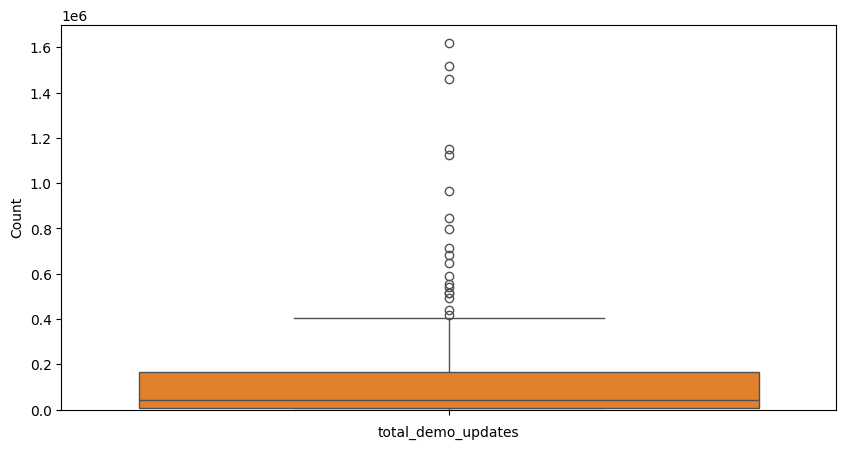

In [18]:
# Distribution
sns.histplot(state_month_demo["total_demo_updates"], bins=50)

# Boxplot
sns.boxplot(y="total_demo_updates", data=state_month_demo)

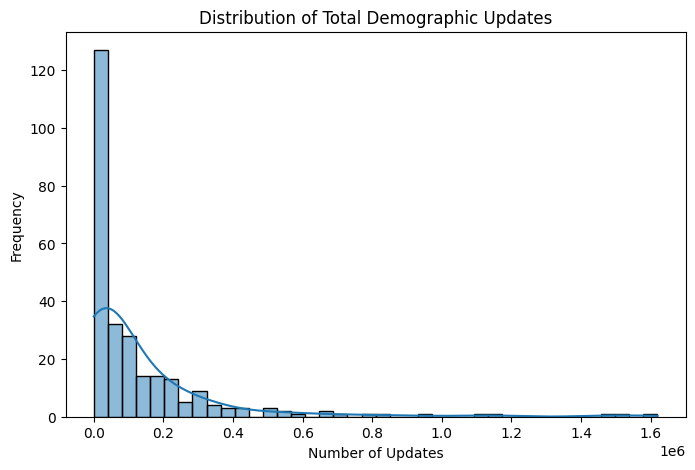

In [26]:
# ----------------------------------------
# 5.1.2 Distribution of total Demographic Updates
# ----------------------------------------

plt.figure(figsize=(8,5))
sns.histplot(
    state_month_demo["total_demo_updates"],
    bins=40,
    kde=True
)
plt.title("Distribution of Total Demographic Updates")
plt.xlabel("Number of Updates")
plt.ylabel("Frequency")
plt.show()



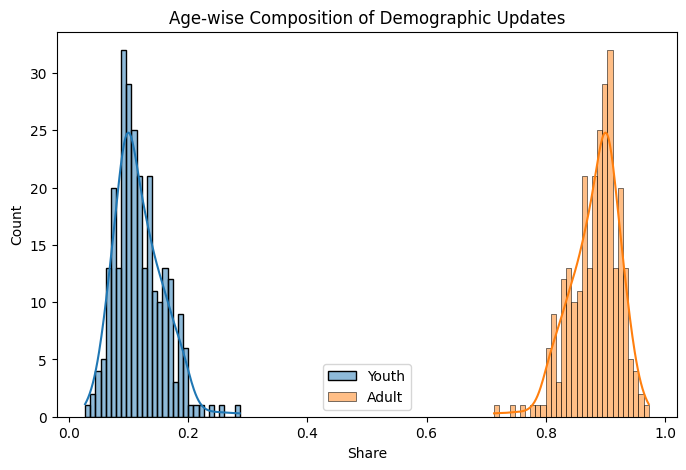

In [27]:
# ----------------------------------------
# 🔹 5.1.3 Youth vs Adult Update Share
# ----------------------------------------

plt.figure(figsize=(8,5))
sns.histplot(state_month_demo["youth_update_share"], bins=30, label="Youth", kde=True)
sns.histplot(state_month_demo["adult_update_share"], bins=30, label="Adult", kde=True)
plt.legend()
plt.title("Age-wise Composition of Demographic Updates")
plt.xlabel("Share")
plt.show()




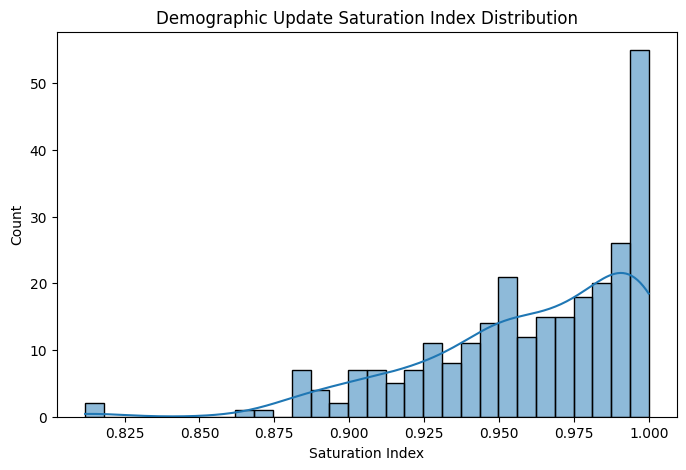

In [28]:
# ----------------------------------------
# 🔹 5.1.4 Update Saturation Distribution
# ----------------------------------------

plt.figure(figsize=(8,5))
sns.histplot(
    state_month_demo["update_saturation_index"],
    bins=30,
    kde=True
)
plt.title("Demographic Update Saturation Index Distribution")
plt.xlabel("Saturation Index")
plt.show()



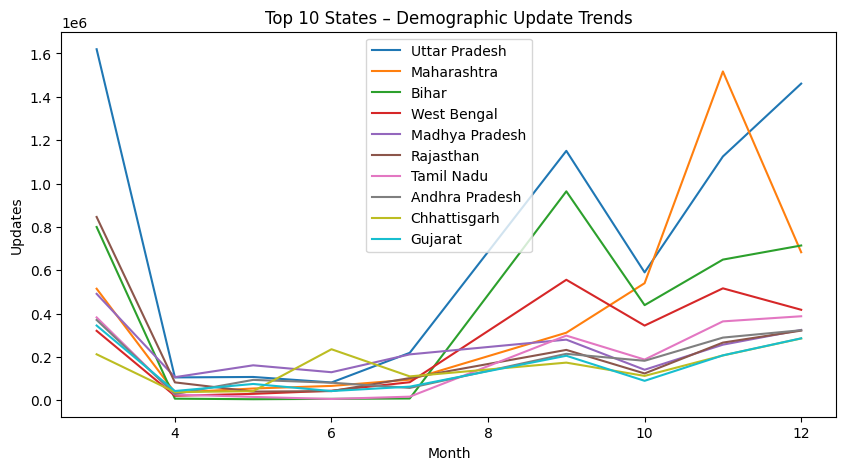

In [29]:
# 🔹 5.2.2 Top 10 States by Update Volume

top_states = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .sum()
    .nlargest(10)
    .index
)

plt.figure(figsize=(10,5))

for state in top_states:
    subset = state_month_demo[state_month_demo["state_clean"] == state]
    plt.plot(
        subset["month"],
        subset["total_demo_updates"],
        label=state
    )

plt.legend()
plt.title("Top 10 States – Demographic Update Trends")
plt.ylabel("Updates")
plt.xlabel("Month")
plt.show()


🔹 5.2 BIVARIATE ANALYSIS

(Relationship between two variables)

🔹 5.2.3 Saturation vs Update Pressure
Interpretation:

Low saturation + high pressure → expanding Aadhaar ecosystem

High saturation + low pressure → maintenance phase

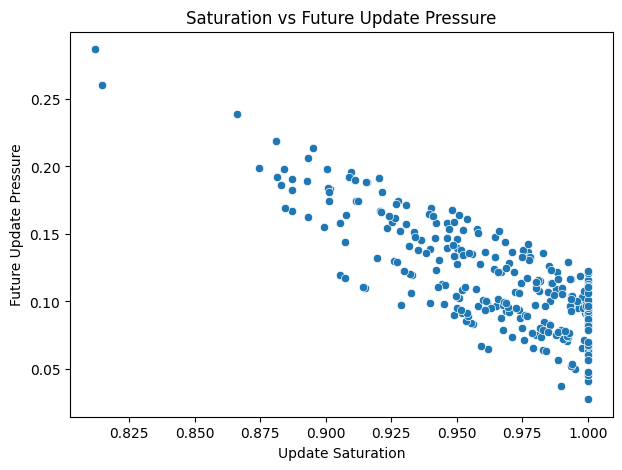

In [30]:
# 🔹 5.2.3 Saturation vs Update Pressure
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=state_month_demo,
    x="update_saturation_index",
    y="future_update_pressure"
)
plt.title("Saturation vs Future Update Pressure")
plt.xlabel("Update Saturation")
plt.ylabel("Future Update Pressure")
plt.show()


🔹 1️⃣ Update Volume vs Volatility
🎯 Purpose:

Identify whether heavy update states are operationally stable or unstable.

✅ Insight

High volume + high volatility
→ infrastructure stress

High volume + low volatility
→ mature update ecosystem

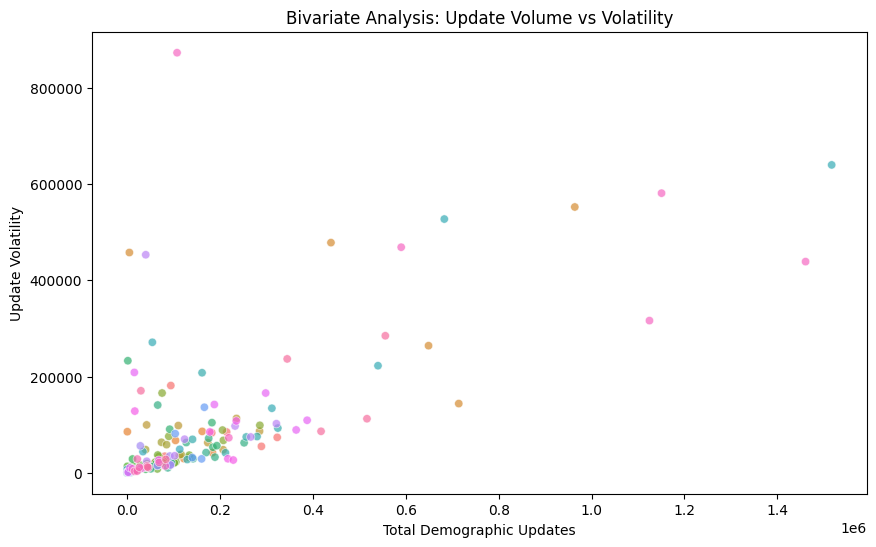

In [31]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=state_month_demo,
    x="total_demo_updates",
    y="update_volatility",
    hue="state_clean",
    alpha=0.7,
    legend=False
)

plt.xlabel("Total Demographic Updates")
plt.ylabel("Update Volatility")
plt.title("Bivariate Analysis: Update Volume vs Volatility")

plt.show()


🔹 2️⃣ Youth Update Share vs Lifecycle Index
🎯 Purpose:

Understand whether updates are lifecycle-driven or random.

✅ Insight

Strong positive slope
→ updates driven by age transitions

Flat relationship
→ irregular or backlog-driven updates

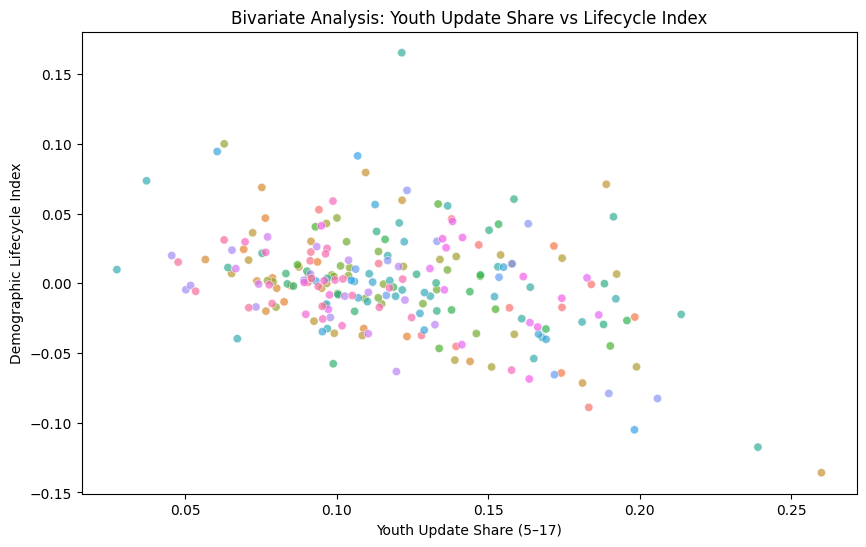

In [32]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=state_month_demo,
    x="youth_update_share",
    y="demographic_lifecycle_index",
    hue="state_clean",
    alpha=0.7,
    legend=False
)

plt.xlabel("Youth Update Share (5–17)")
plt.ylabel("Demographic Lifecycle Index")
plt.title("Bivariate Analysis: Youth Update Share vs Lifecycle Index")

plt.show()


🔹 3️⃣ Update Saturation vs Growth
🎯 Purpose:

Detect states approaching update exhaustion

✅ Insight

High saturation + negative growth
→ nearing update completion

Low saturation + high growth
→ active update phase

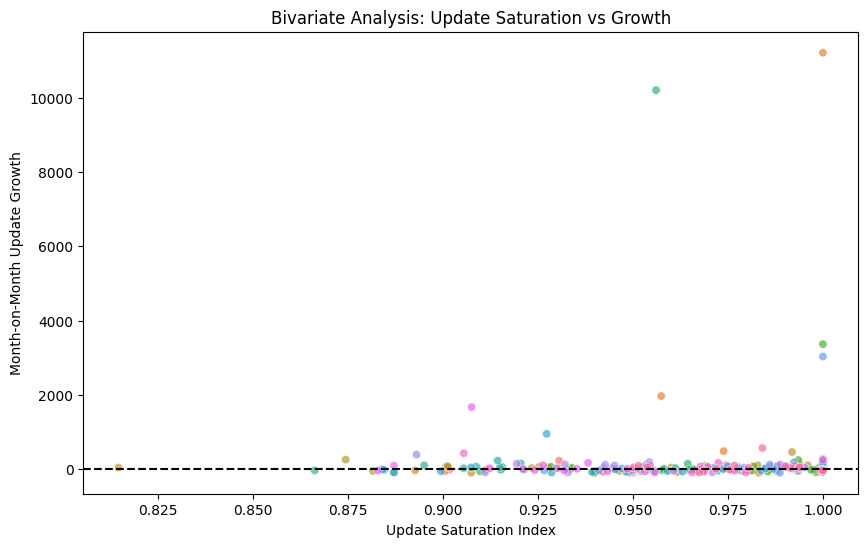

In [33]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=state_month_demo,
    x="update_saturation_index",
    y="mom_update_growth",
    hue="state_clean",
    alpha=0.7,
    legend=False
)

plt.axhline(0, linestyle="--", color="black")

plt.xlabel("Update Saturation Index")
plt.ylabel("Month-on-Month Update Growth")
plt.title("Bivariate Analysis: Update Saturation vs Growth")

plt.show()


🔹 5.3 TRIVARIATE ANALYSIS

(Time × Geography × Demography)

🔹 1️⃣ Age × Time × Update Volume
🎯 Purpose

Understand which age group dominates updates over time.

✅ Insight

Youth-heavy states show periodic education-driven updates

Adult updates dominate migration & correction cycles

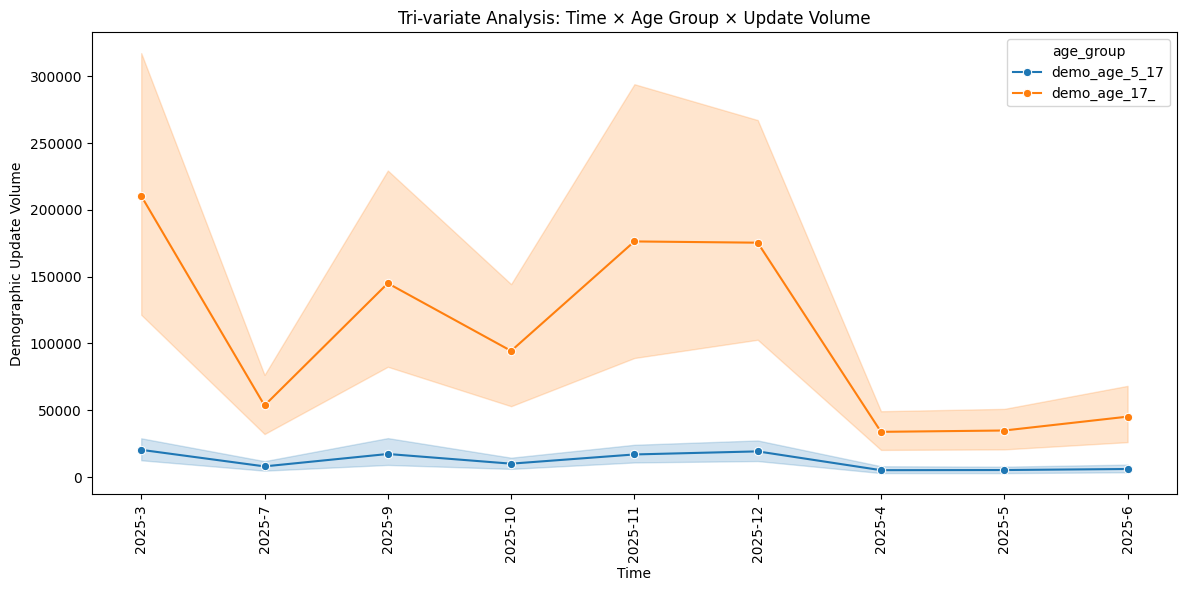

In [34]:
demo_long = state_month_demo.melt(
    id_vars=["year", "month"],
    value_vars=["demo_age_5_17", "demo_age_17_"],
    var_name="age_group",
    value_name="update_volume"
)

demo_long["period"] = demo_long["year"].astype(str) + "-" + demo_long["month"].astype(str)

plt.figure(figsize=(14,6))

sns.lineplot(
    data=demo_long,
    x="period",
    y="update_volume",
    hue="age_group",
    marker="o"
)

plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Demographic Update Volume")
plt.title("Tri-variate Analysis: Time × Age Group × Update Volume")

plt.show()


🔹 2️⃣ Update Saturation × Time × State
🎯 Purpose

Detect update exhaustion or backlog accumulation.

✅ Insight

Darker states → nearing update saturation

Lighter states → future update pressure expected

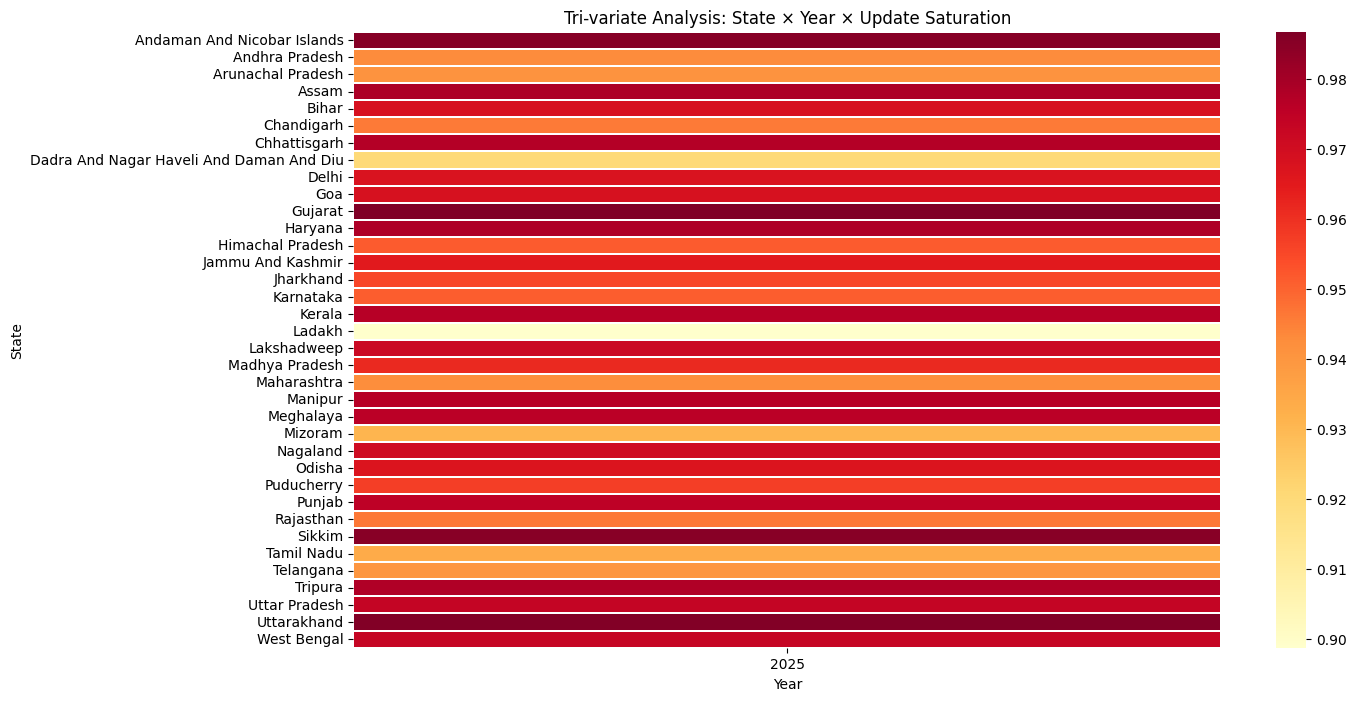

In [35]:
pivot_sat = state_month_demo.pivot_table(
    index="state_clean",
    columns="year",
    values="update_saturation_index",
    aggfunc="mean"
)

plt.figure(figsize=(14,8))

sns.heatmap(
    pivot_sat,
    cmap="YlOrRd",
    linewidths=0.3
)

plt.title("Tri-variate Analysis: State × Year × Update Saturation")
plt.xlabel("Year")
plt.ylabel("State")

plt.show()


🔹 3️⃣ Update Volume × Volatility × Growth
🎯 Purpose

Identify operational stress vs stability zones.

✅ Insight

Large bubbles = rapid change states

High volatility + large size → governance instability

Low volatility + medium volume → mature systems

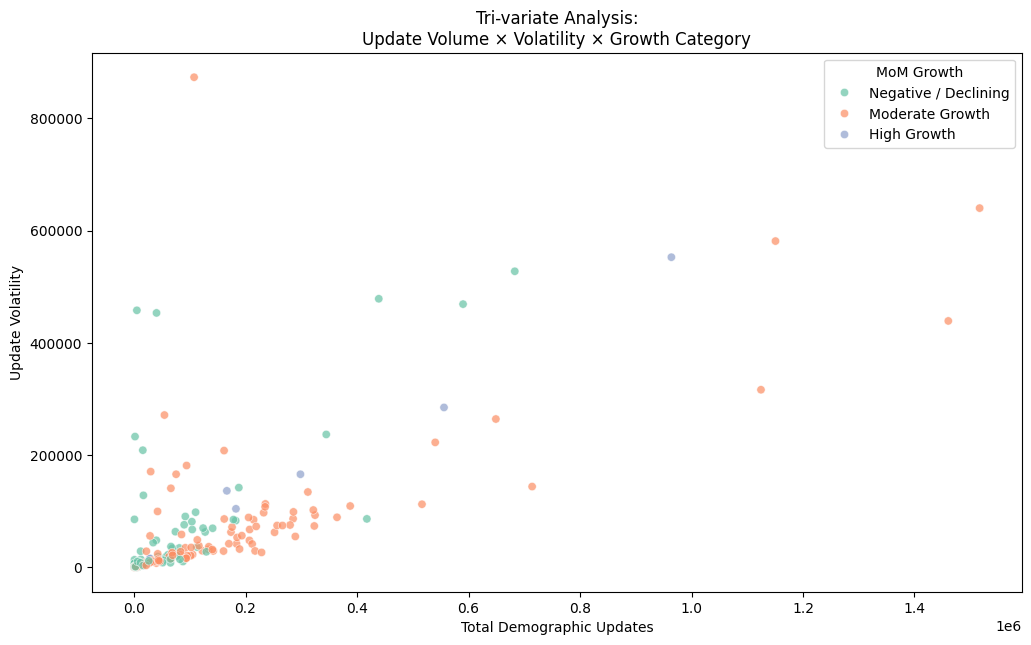

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------
# Create growth category
# --------------------------------------------------
state_month_demo["growth_category"] = pd.cut(
    state_month_demo["mom_update_growth"],
    bins=[-np.inf, 0, 500, np.inf],
    labels=["Negative / Declining", "Moderate Growth", "High Growth"]
)

# --------------------------------------------------
# Tri-variate scatter (NO bubble)
# --------------------------------------------------
plt.figure(figsize=(12,7))

sns.scatterplot(
    data=state_month_demo,
    x="total_demo_updates",
    y="update_volatility",
    hue="growth_category",
    palette="Set2",
    alpha=0.7
)

plt.xlabel("Total Demographic Updates")
plt.ylabel("Update Volatility")
plt.title(
    "Tri-variate Analysis:\n"
    "Update Volume × Volatility × Growth Category"
)

plt.legend(title="MoM Growth")

plt.show()


🔹 4️⃣ Lifecycle Index × Governance Load × Update Volume
🎯 Purpose

Understand administrative burden vs lifecycle maturity.
✅ Insight

| Pattern                          | Meaning                 |
| -------------------------------- | ----------------------- |
| High lifecycle + high governance | Scheduled update stress |
| Low lifecycle + high governance  | Policy or awareness gap |
| High lifecycle + low governance  | Efficient update system |


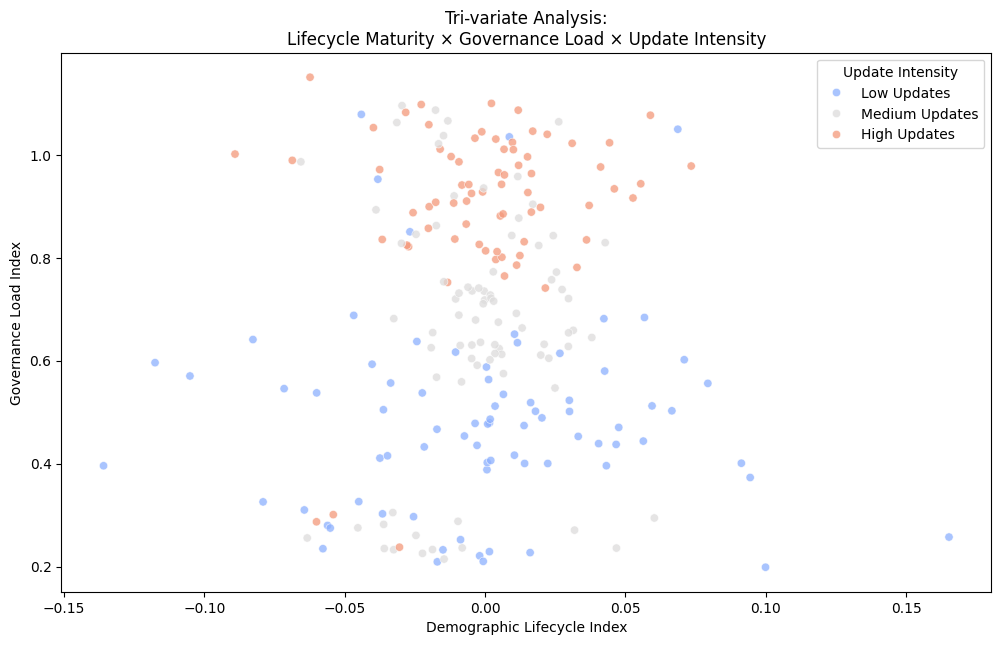

In [36]:
# --------------------------------------------------
# Create update intensity tiers
# --------------------------------------------------
state_month_demo["update_intensity"] = pd.qcut(
    state_month_demo["total_demo_updates"],
    q=3,
    labels=["Low Updates", "Medium Updates", "High Updates"]
)

# --------------------------------------------------
# Tri-variate scatter (faceted)
# --------------------------------------------------
plt.figure(figsize=(12,7))

sns.scatterplot(
    data=state_month_demo,
    x="demographic_lifecycle_index",
    y="governance_load_index",
    hue="update_intensity",
    palette="coolwarm",
    alpha=0.75
)

plt.xlabel("Demographic Lifecycle Index")
plt.ylabel("Governance Load Index")
plt.title(
    "Tri-variate Analysis:\n"
    "Lifecycle Maturity × Governance Load × Update Intensity"
)

plt.legend(title="Update Intensity")
plt.show()


🔹 3️⃣ Time × Age Group × Update Volume (Line Facet)

This is extremely powerful for policy reviewers.

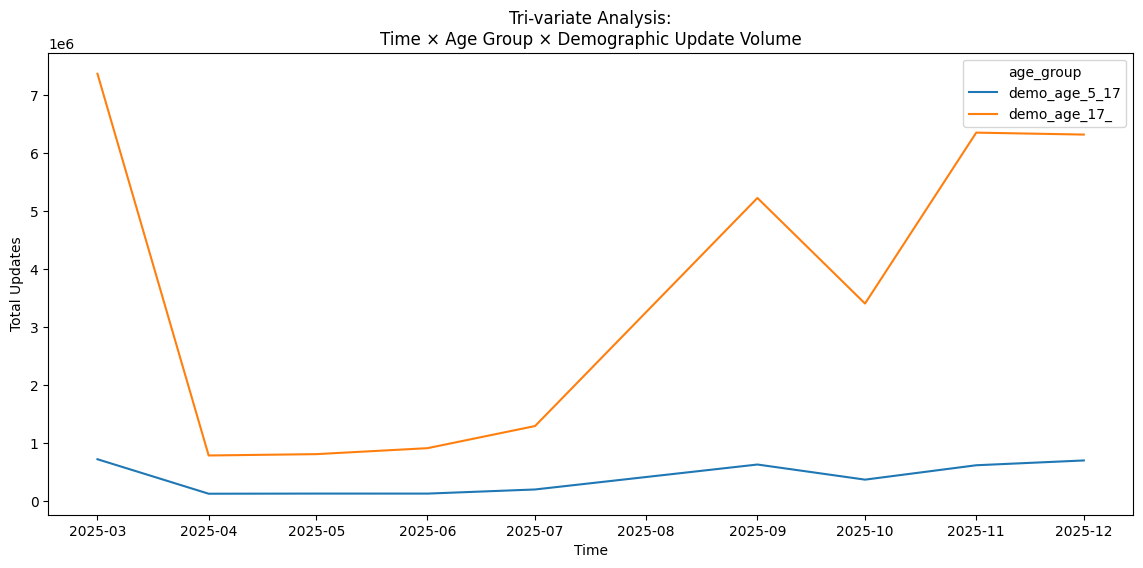

In [38]:
# Reshape age columns
age_long = state_month_demo.melt(
    id_vars=["state_clean", "year", "month"],
    value_vars=["demo_age_5_17", "demo_age_17_"],
    var_name="age_group",
    value_name="updates"
)

age_long["date"] = pd.to_datetime(
    age_long["year"].astype(str) + "-" +
    age_long["month"].astype(str) + "-01"
)

plt.figure(figsize=(14,6))

sns.lineplot(
    data=age_long,
    x="date",
    y="updates",
    hue="age_group",
    estimator="sum",
    errorbar=None
)

plt.title(
    "Tri-variate Analysis:\n"
    "Time × Age Group × Demographic Update Volume"
)

plt.xlabel("Time")
plt.ylabel("Total Updates")
plt.show()


Monthly update trends

Rolling momentum

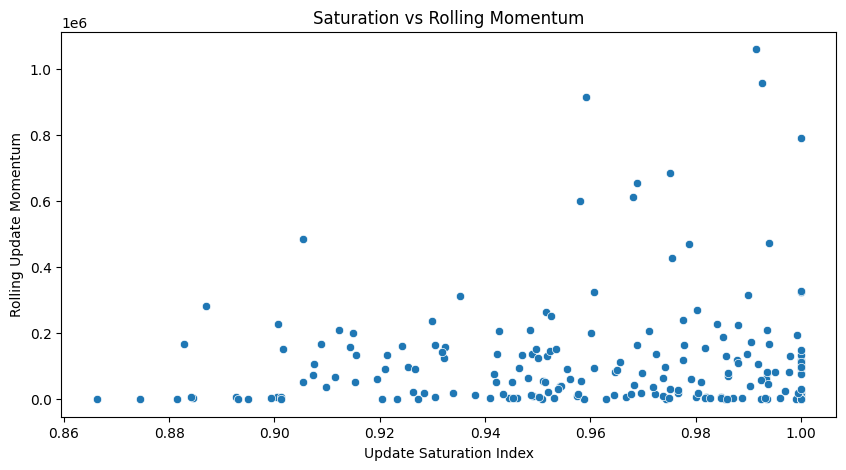

In [25]:
sns.scatterplot(
    x="update_saturation_index",
    y="rolling_update_momentum",
    data=state_month_demo
)
plt.title("Saturation vs Rolling Momentum")
plt.xlabel("Update Saturation Index")
plt.ylabel("Rolling Update Momentum")
plt.show()

# 6. Advanced Analytical Indicators

Aadhaar Demographic Update Dataset

6.1 Update Saturation Index (USI)
Measures maturity of update activity

Interpretation:

Low value → under-penetrated update ecosystem

High value → nearing saturation

In [32]:
state_month_demo["update_saturation_index"] = (
    state_month_demo["total_demo_updates"] /
    state_month_demo.groupby("state_clean")["total_demo_updates"].transform("max")
)
state_month_demo[[
    "state_clean", "year", "month",
    "update_saturation_index"
]].head()

,state_clean,year,month,update_saturation_index
0,Andaman And Nicobar Islands,2025,3,0.716154
1,Andaman And Nicobar Islands,2025,7,0.168462
2,Andaman And Nicobar Islands,2025,9,0.475385
3,Andaman And Nicobar Islands,2025,10,0.348462
4,Andaman And Nicobar Islands,2025,11,0.702308


6.2 Rolling Update Momentum (3-Month)

Captures sustained administrative pressure

In [33]:
state_month_demo = state_month_demo.sort_values(
    ["state_clean", "year", "month"]
)

state_month_demo["rolling_update_momentum"] = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)
state_month_demo[[
    "state_clean", "year", "month",
    "rolling_update_momentum"
]].head()

,state_clean,year,month,rolling_update_momentum
0,Andaman And Nicobar Islands,2025,3,931.000000
1,Andaman And Nicobar Islands,2025,7,575.000000
2,Andaman And Nicobar Islands,2025,9,589.333333
3,Andaman And Nicobar Islands,2025,10,430.000000
4,Andaman And Nicobar Islands,2025,11,661.333333


6.3 Month-on-Month Update Growth

In [34]:
state_month_demo["mom_update_growth"] = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .pct_change()
)
state_month_demo[[
    "state_clean", "year", "month",
    "mom_update_growth"
]].head()

,state_clean,year,month,mom_update_growth
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,-0.764769
2,Andaman And Nicobar Islands,2025,9,1.821918
3,Andaman And Nicobar Islands,2025,10,-0.266990
4,Andaman And Nicobar Islands,2025,11,1.015453


🔹 6.4 Age-Shift Momentum

Identifies lifecycle-driven update demand

Meaning:

Positive → adult updates dominate

Negative → child → youth transitions ongoing

In [35]:
state_month_demo["age_shift_momentum"] = (
    state_month_demo["demo_age_17_"] -
    state_month_demo["demo_age_5_17"]
)

6.5 Demographic Lifecycle Pressure Index

In [36]:
state_month_demo["demographic_lifecycle_index"] = (
    state_month_demo["age_shift_momentum"] /
    state_month_demo["total_demo_updates"]
).fillna(0)


6.6 Update Volatility Index

Operational instability detector

In [37]:
state_month_demo["update_volatility"] = (
    state_month_demo
    .groupby("state_clean")["total_demo_updates"]
    .rolling(window=6, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
)

6.7 Future Update Pressure Score

In [38]:
state_month_demo["future_update_pressure"] = (
    (1 - state_month_demo["update_saturation_index"]) *
    state_month_demo["rolling_update_momentum"]
)

6.8 Coverage Inequality Index (Cross-Dataset)
Enrolment × Demographic Update

✅ Interpretation

| Value | Meaning                                             |
| ----- | --------------------------------------------------- |
| > 1.0 | More updates than new enrolments (aging population) |
| ≈ 1.0 | Balanced lifecycle                                  |
| < 0.3 | Expansion phase                                     |
| ≈ 0   | New enrolment dominant                              |


In [39]:
import pandas as pd
# Requires Dataset-1 aggregated at same level.
# Load enrolment aggregation
enrolment_state_month = pd.read_csv(
    "../api_data_aadhar_enrolment/state_month.csv"
)

coverage_merge = pd.merge(
    enrolment_state_month[
        ["state_clean", "year", "month", "total_enrolment"]
    ],
    state_month_demo,
    on=["state_clean", "year", "month"],
    how="inner"
)
coverage_merge["update_to_enrolment_ratio"] = (
    (coverage_merge["demo_age_5_17"] + coverage_merge["demo_age_17_"])
    / coverage_merge["total_enrolment"].replace(0, np.nan)
)
coverage_merge.head(30)

,state_clean,year,month,total_enrolment,demo_age_5_17,demo_age_17_,total_demo_updates,youth_update_share,adult_update_share,update_saturation_index,future_update_pressure,mom_update_growth,rolling_update_momentum,update_volatility,demographic_lifecycle_index,governance_load_index,age_shift_momentum,update_to_enrolment_ratio
0,Andaman And Nicobar Islands,2025,9,145,56,562,618,0.090615,0.909385,0.475385,309.173333,1.821918,589.333333,356.864587,0.818770,0.388013,506,4.262069
1,Andaman And Nicobar Islands,2025,10,60,58,395,453,0.128035,0.871965,0.348462,280.161538,-0.266990,430.000000,299.246136,0.743929,0.410563,337,7.550000
2,Andaman And Nicobar Islands,2025,11,88,104,809,913,0.113910,0.886090,0.702308,196.873846,1.015453,661.333333,304.562309,0.772180,0.400156,705,10.375000
3,Andaman And Nicobar Islands,2025,12,97,119,1181,1300,0.091538,0.908462,1.000000,0.000000,0.423877,888.666667,386.962014,0.816923,0.400089,1062,13.402062
4,Andhra Pradesh,2025,3,116,34912,335783,370695,0.094180,0.905820,1.000000,0.000000,NaN,370695.000000,NaN,0.811640,0.229868,300871,3195.646552
5,Andhra Pradesh,2025,6,1574,14158,67023,81181,0.174400,0.825600,0.218997,53294.360152,-0.138919,68238.333333,153812.901042,0.651199,0.862133,52865,51.576239
6,Andhra Pradesh,2025,7,956,8413,48846,57259,0.146929,0.853071,0.154464,65590.489080,-0.294675,77572.666667,138720.918551,0.706142,0.738007,40433,59.894351
7,Andhra Pradesh,2025,9,40355,20202,194264,214466,0.094197,0.905803,0.578551,49577.281839,2.745542,117635.333333,129164.520004,0.811607,0.915758,174062,5.314484
8,Andhra Pradesh,2025,10,24567,33418,148958,182376,0.183237,0.816763,0.491984,76896.861498,-0.149627,151367.000000,72842.459529,0.633526,1.001081,115540,7.423617
9,Andhra Pradesh,2025,11,33779,53248,236037,289285,0.184068,0.815932,0.780385,50227.814484,0.586201,228709.000000,90539.584579,0.631865,0.927562,182789,8.564049


# 7: ANOMALY DETECTION

7.1 Z-Score Based Update Spike Detection

In [40]:
state_month_demo["update_zscore"] = (
    state_month_demo.groupby("state_clean")["total_demo_updates"]
    .transform(lambda x: (x - x.mean()) / x.std())
)
state_month_demo[[
    "state_clean", "year", "month",
    "update_zscore"
]].head()

,state_clean,year,month,update_zscore
0,Andaman And Nicobar Islands,2025,3,0.496173
1,Andaman And Nicobar Islands,2025,7,-1.343801
2,Andaman And Nicobar Islands,2025,9,-0.312692
3,Andaman And Nicobar Islands,2025,10,-0.739091
4,Andaman And Nicobar Islands,2025,11,0.449657


In [41]:
state_month_demo["is_anomaly"] = (
    state_month_demo["update_zscore"].abs() > 3
)
state_month_demo[[
    "state_clean", "year", "month",
    "is_anomaly"
]].head()

,state_clean,year,month,is_anomaly
0,Andaman And Nicobar Islands,2025,3,False
1,Andaman And Nicobar Islands,2025,7,False
2,Andaman And Nicobar Islands,2025,9,False
3,Andaman And Nicobar Islands,2025,10,False
4,Andaman And Nicobar Islands,2025,11,False


In [42]:
state_month_demo[state_month_demo["is_anomaly"]][
    ["state_clean", "year", "month", "total_demo_updates", "update_zscore"]
].sort_values("update_zscore", ascending=False)

,state_clean,year,month,total_demo_updates,update_zscore


# 8. DECISION MATRIX & POLICY FRAMEWORK

8.1 Governance Risk Score

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

state_month_demo[
    [
        "norm_saturation",
        "norm_lifecycle",
        "norm_volatility"
    ]
] = scaler.fit_transform(
    state_month_demo[
        [
            "update_saturation_index",
            "demographic_lifecycle_index",
            "update_volatility"
        ]
    ]
)
state_month_demo["governance_load_index"] = (
    state_month_demo["norm_saturation"] +
    state_month_demo["norm_lifecycle"] +
    state_month_demo["norm_volatility"]
) / 3
state_month_demo[[
    "state_clean", "year", "month",
    "governance_load_index"
]].head()


,state_clean,year,month,governance_load_index
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,0.306552
2,Andaman And Nicobar Islands,2025,9,0.410125
3,Andaman And Nicobar Islands,2025,10,0.319528
4,Andaman And Nicobar Islands,2025,11,0.456096


In [44]:
state_month_demo["governance_risk_score"] = (
    state_month_demo["norm_lifecycle"] +
    state_month_demo["norm_volatility"] +
    (1 - state_month_demo["norm_saturation"])
)
state_month_demo[[
    "state_clean", "year", "month",
    "governance_risk_score"
]].head()

,state_clean,year,month,governance_risk_score
0,Andaman And Nicobar Islands,2025,3,NaN
1,Andaman And Nicobar Islands,2025,7,1.589215
2,Andaman And Nicobar Islands,2025,9,1.283694
3,Andaman And Nicobar Islands,2025,10,1.266738
4,Andaman And Nicobar Islands,2025,11,0.965995


8.2 Policy Classification

In [45]:
def policy_bucket(row):
    if row["governance_risk_score"] >= 2.2:
        return "Immediate Intervention"
    elif row["governance_risk_score"] >= 1.5:
        return "Capacity Expansion"
    elif row["governance_risk_score"] >= 0.8:
        return "Routine Monitoring"
    else:
        return "Stable"

state_month_demo["policy_action"] = state_month_demo.apply(
    policy_bucket, axis=1
)
state_month_demo[[
    "state_clean", "year", "month",
    "policy_action"
]].head()

,state_clean,year,month,policy_action
0,Andaman And Nicobar Islands,2025,3,Stable
1,Andaman And Nicobar Islands,2025,7,Capacity Expansion
2,Andaman And Nicobar Islands,2025,9,Routine Monitoring
3,Andaman And Nicobar Islands,2025,10,Routine Monitoring
4,Andaman And Nicobar Islands,2025,11,Routine Monitoring


# 9. STORYTELLING VISUALS

9.1 Saturation Shift (Early vs Late)

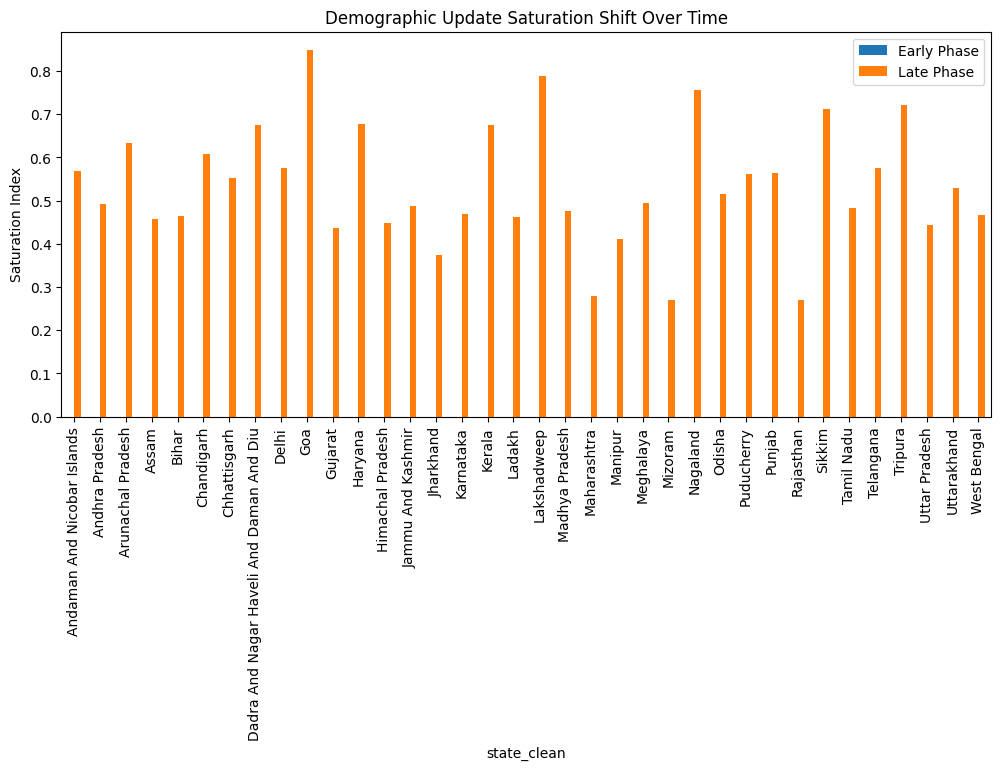

In [46]:
early = state_month_demo[state_month_demo["year"] <= 2020]
late  = state_month_demo[state_month_demo["year"] >= 2023]

sat_compare = pd.DataFrame({
    "Early Phase": early.groupby("state_clean")["update_saturation_index"].mean(),
    "Late Phase":  late.groupby("state_clean")["update_saturation_index"].mean()
})

sat_compare.plot(kind="bar", figsize=(12,5))
plt.title("Demographic Update Saturation Shift Over Time")
plt.ylabel("Saturation Index")
plt.show()


9.2 Heatmap — State × Year

Text(0.5, 1.0, 'Heatmap of Total Demographic Updates by State and Year')

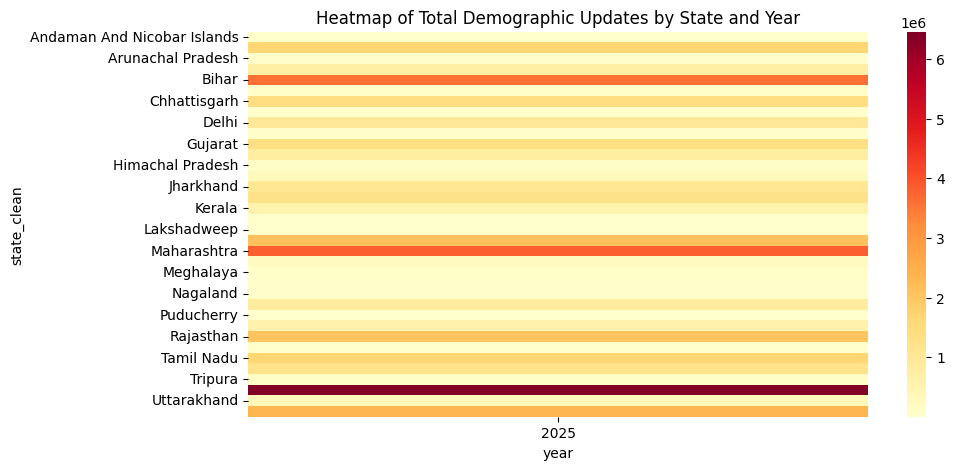

In [47]:
pivot = state_month_demo.pivot_table(
    index="state_clean",
    columns="year",
    values="total_demo_updates",
    aggfunc="sum"
)

sns.heatmap(pivot, cmap="YlOrRd")
plt.title("Heatmap of Total Demographic Updates by State and Year")

9.3 Policy Category Distribution

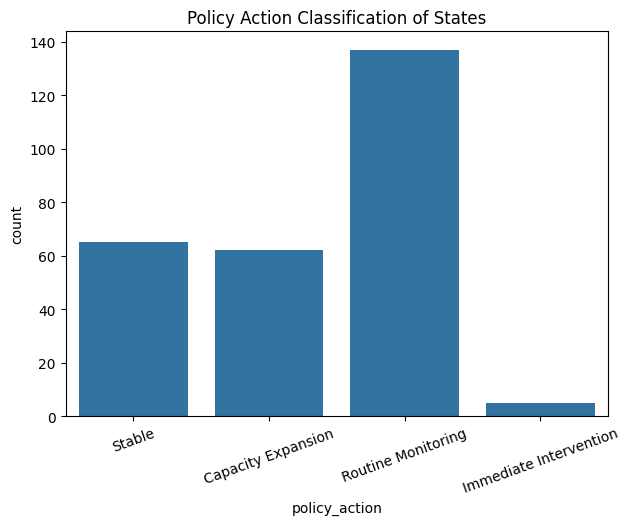

In [48]:
plt.figure(figsize=(7,5))
sns.countplot(
    data=state_month_demo,
    x="policy_action"
)
plt.title("Policy Action Classification of States")
plt.xticks(rotation=20)
plt.show()


In [ ]:
state_month_demo.to_csv(
    "state_month_demographic.csv",
    index=False
)